In [32]:
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.stats import poisson
import math
from collections import defaultdict
plt.rcParams['figure.dpi'] = 100

## Defining the Parameters

In [33]:
N = 200 # number of nodes 200
Q = 4 # number of groups
q = 50 # group size 50
mu = 0.025 # outside connections (Mxing parameter)
beta = 0.4 # infection rate
r = 1 # recovery rate
k_avg = 3 # average degree 


### Assigning Communities

In [34]:
commu_names = [ _ for _ in range(1,(Q+1))] # name of the communities
G = nx.Graph()
for i in range(N): # assigning the communities as attributes to the graph
    G.add_node(i, community =  math.floor(i/q) + 1)


## Community Structure

### Stochastic-Block Model (SBM)

In [35]:
def create_SBM(G, Q, q, mu, k_avg):
    G_copy = G.copy()
    p_in = k_avg*(1-mu)/(q-1) # probability of interactions within a group
    p_out = k_avg*mu/(N-q) # probability of interactions with nodes outside of its own group

    for i in G_copy:
        groupmates = [node for node, attrs in G_copy.nodes(data=True) if attrs.get('community') == math.floor(i/q)+1 and node != i]
        outsiders = [node for node, attrs in G_copy.nodes(data=True) if attrs.get('community') != math.floor(i/q)+1 ]
        for neighbor in groupmates: 
            if np.random.rand() < p_in:
                G_copy.add_edge(i, neighbor)
        for outsider in outsiders:
            if np.random.rand() < p_out:
                G_copy.add_edge(i, outsider)
    return G_copy




## Measuring Correlation Among the Community Structures of the Layers

##### Maximally Correlated Communities

In [23]:
# Normalized Mutual Information (NMI) = 1
G1 = create_SBM(G, Q, q, mu, k_avg)
G2 = create_SBM(G, Q, q, mu, k_avg)

##### Un-Correlated Communities

In [36]:
# NMI = 0

def swapping_communities(G, r):
    G_copy = G.copy()
    nodes = list(G_copy.nodes())
    np.random.shuffle(nodes)
    while nodes:
        current_node = nodes.pop()
        outsiders = [node for node in nodes if G_copy.nodes[node]["community"] != G_copy.nodes[current_node]["community"]]
        
        if not outsiders:
            continue

        swap_candidate = np.random.choice(outsiders)

        if np.random.rand() < r:
            G_copy.nodes[current_node]["community"] , G_copy.nodes[swap_candidate]["community"] = \
            G_copy.nodes[swap_candidate]["community"] , G_copy.nodes[current_node]["community"]
            nodes.remove(swap_candidate)

    return G_copy

In [37]:
r = 1 # the probablity of swapping edges 
# community_membership_layer2 = community_membership_layer1
G1 = create_SBM(G, Q, q, mu, k_avg)
G2 = swapping_communities(G, r)
G2 = create_SBM(G2, Q, q, mu, k_avg)

##### Plot 

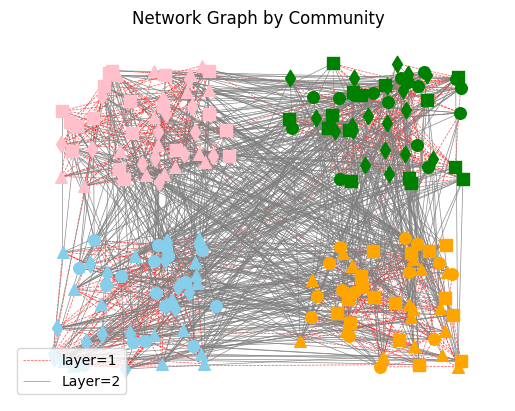

<Figure size 600x600 with 0 Axes>

In [ ]:
def custom_layout_by_community_attribute(G, frame_size=(1, 1), padding=0.1, inner_padding=0.05):
    positions = {}
    width, height = frame_size
    communities = set(nx.get_node_attributes(G, 'community').values())  # Extract unique community IDs
    num_communities = len(communities)
    sqrt_num = int(np.ceil(np.sqrt(num_communities)))  # Arrange in a square layout
    community_size = (width - 2 * padding) / sqrt_num
    
    for community_id in communities:
        i = list(communities).index(community_id)  # Convert to list to get index
        center_x = padding + (i % sqrt_num) * community_size + community_size / 2
        center_y = height - (padding + (i // sqrt_num) * community_size + community_size / 2)
        
        nodes_in_community = [node for node, data in G.nodes(data=True) if data.get('community') == community_id]
        for node in nodes_in_community:
            x = center_x + np.random.uniform(-community_size / 2 + inner_padding, community_size / 2 - inner_padding)
            y = center_y + np.random.uniform(-community_size / 2 + inner_padding, community_size / 2 - inner_padding)
            positions[node] = (x, y)
    
    return positions

# Create a custom layout based on community
pos = custom_layout_by_community_attribute(G1)

color_mapping = {1: 'pink', 2: 'green', 3: 'skyblue', 4: 'orange'}
shape_mapping = {1: 'o', 2: '^', 3: 's', 4: 'd'}  # Circle, Triangle, Square, diamond

# adding the attributes of the second layer to G1 for plotting. 
communities_layer2 = list(nx.get_node_attributes(G2, 'community').values())  # Extract unique community IDs
for i in range(N):
    G1.nodes[i]['community_layer2'] = communities_layer2[i]


for node, data in G1.nodes(data=True):
    nx.draw_networkx_nodes(G1, pos, nodelist=[node], 
                           node_color=color_mapping[data['community']],
                           node_shape=shape_mapping[data['community_layer2']], 
                           node_size=70)

# Plot edges for G1
nx.draw_networkx_edges(G1, pos, edge_color='red', style='dashed', width=0.5, alpha =0.7, label = "layer=1")

# # Optionally, plot edges for G2 if needed
nx.draw_networkx_edges(G2, pos, edge_color='gray', style='solid', width =0.5, alpha = 0.9, label = "Layer=2")
plt.title("Network Graph by Community")
plt.legend(loc = "lower left")
plt.axis('off')  # Turn off the axis

# Plotting
plt.figure(figsize=(6, 6))
# Draw nodes with colors based on their community


plt.show()


## Disease Dynamics

In [ ]:

def SIR_dynamics(G, beta, r):
    # initial conditions:
    I = {np.random.choice(G.nodes())} # starting with one random infected individual
    S = set(G.nodes()) - I # all the remaining individuals are the susceptibles
    R = set()

    S_records, I_records, R_records = [], [], [] # keeping records of how the networks evolves

    # max_t = 1000 

    while len(I) != 0: 
        I_temp, R_temp = set(), set() # defining these temporary sets to avoid infinite loops
        for i in I: # at each time step every infected, infects its neighbors with probability (at rate) beta
            for neighbor in G.neighbors(i):
                if neighbor in S: 
                    if np.random.rand() < beta:
                        I_temp.add(neighbor)
            if np.random.rand() < r:
                R_temp.add(i)
        
        S -= I_temp
        I = (I - R_temp) | I_temp
        R |= R_temp 

        S_records.append(S)
        I_records.append(I)
        R_records.append(R)
        
        # if len(I) == 0:
        #     break

    return S_records,I_records, R_records
